# Training an intents classification model

Define constants

In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

DATA_UTILS = path.join(BASE_PATH, 'common/data_utils.py')
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
CLASSES_FILE = path.join(BASE_PATH, 'classes.json')

from text_classification.crnn.train import trainIters

In [2]:
exec(open(DATA_UTILS).read())

Use functions from the utils to extract and preprocess the training data
Refer to `kc_data.json` for the sample data format
`get_data_pairs` is then used to parse data into a tuple of `([list_of_sentences], [list_of_labels])`

In [3]:
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

classes = list(set(y_data))
num_classes = len(classes)

X_train = X_data
y_train = np.array([
    classes.index(item)
    for item in y_data
], dtype='float32')

Plot the training data

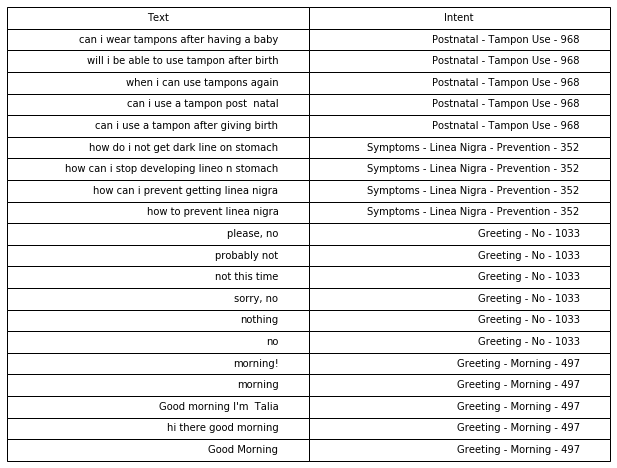

In [4]:
cell_text = [
    [item, y_data[idx] + ' - ' + str(int(y_train[idx]))] 
    for (idx, item) in enumerate(X_train)
]
plt.table(cellText=cell_text[:20],
          colLabels=['Text', 'Intent'],
          loc='center') \
   .scale(1.8,1.8)
plt.axis('off')
plt.show()

In [5]:
print('Number of samples: %s, classes: %s' % (len(X_train), num_classes))

Number of samples: 10256, classes: 1427


Save the classes descriptions as json

In [6]:
import json

with open(CLASSES_FILE, 'w') as classes_file:
    json.dump(classes, classes_file)

Start training the classification model and save

In [7]:
training_data = [(item, y_train[idx]) for idx, item in enumerate(X_train)]

model = trainIters(training_data, classes, n_iters=200, log_every=5, verbose=1, batch_size=128)

Importing /Users/2359media/Documents/botbot-nlp/data/glove/glove.6B.300d.pickle...
16m 35s (- 647m 2s) (5 2%) 588.4603 - accuracy: 0.0044
29m 31s (- 561m 3s) (10 5%) 563.8575 - accuracy: 0.0255
45m 28s (- 560m 45s) (15 7%) 508.6432 - accuracy: 0.0615
61m 18s (- 551m 47s) (20 10%) 438.8279 - accuracy: 0.1350
497m 48s (- 3484m 36s) (25 12%) 373.8076 - accuracy: 0.2168
509m 4s (- 2884m 45s) (30 15%) 314.0108 - accuracy: 0.2871
520m 6s (- 2451m 54s) (35 17%) 266.0071 - accuracy: 0.3721
530m 59s (- 2123m 57s) (40 20%) 228.1901 - accuracy: 0.4328
541m 50s (- 1866m 20s) (45 22%) 195.5777 - accuracy: 0.5158
552m 44s (- 1658m 14s) (50 25%) 168.4786 - accuracy: 0.5817
639m 39s (- 1686m 23s) (55 27%) 148.0796 - accuracy: 0.6213
673m 26s (- 1571m 22s) (60 30%) 131.5362 - accuracy: 0.6527
765m 53s (- 1590m 42s) (65 32%) 118.2172 - accuracy: 0.6815
825m 15s (- 1532m 37s) (70 35%) 106.1184 - accuracy: 0.7078
930m 59s (- 1551m 39s) (75 37%) 96.4549 - accuracy: 0.7295
983m 21s (- 1475m 2s) (80 40%) 89.

Test the trained model

In [8]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from common.utils import argmax

from text_classification.crnn.predict import *

TEST_SENTENCE = 'I have a fever'

tokens_in = wordpunct_tokenize(TEST_SENTENCE)
sentence_in = prepare_vec_sequence(tokens_in, word_to_vec, SENTENCE_DIM, output='variable')
result = model(sentence_in.unsqueeze(0)) # Add a batch dimension
result = F.softmax(result, dim=1)
max_idx = argmax(result)
print((classes[max_idx], result[0][max_idx]))

('Birth - Caesarean - Doctor IC', Variable containing:
 0.3789
[torch.FloatTensor of size 1]
)


Getting the top 5 results

In [9]:
from common.utils import to_scalar

topk_probs, topk_idxs = result.topk(5, dim=1)

for idx, result_idx in enumerate(topk_idxs[0]):
    print((classes[to_scalar(result_idx)], topk_probs[0][idx]))

('Birth - Caesarean - Doctor IC', Variable containing:
 0.3789
[torch.FloatTensor of size 1]
)
('Symptoms - Diarrhoea - Normal', Variable containing:
 0.1809
[torch.FloatTensor of size 1]
)
('Symptoms - Diarrhoea - Why', Variable containing:
1.00000e-02 *
  9.6324
[torch.FloatTensor of size 1]
)
('Symptoms - Hunger - Why', Variable containing:
1.00000e-02 *
  6.1369
[torch.FloatTensor of size 1]
)
('Symptoms - LegCramps', Variable containing:
1.00000e-02 *
  3.9670
[torch.FloatTensor of size 1]
)
